<a href="https://colab.research.google.com/github/zeerafle/corn-disease/blob/master/notebook_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow scikeras databricks-sdk -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
!pip install --upgrade polars -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 16.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -r /content/drive/MyDrive/corn-disease/data /content/
!mkdir .artifacts

In [5]:
import random

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

plt.style.use('ggplot')

In [6]:
mlflow.login()

2024/07/15 08:54:30 INFO mlflow.utils.credentials: No valid Databricks credentials found, please enter your credentials...


Databricks Host (should begin with https://): https://community.cloud.databricks.com
Username: vsefareez@student.unmul.ac.id
Password: ··········


2024/07/15 08:54:49 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [7]:
target = 'labels'
class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']

In [8]:
train = pl.read_parquet('data/train_data.parquet')
val = pl.read_parquet('data/validation_data.parquet')
test = pl.read_parquet('data/test_data.parquet')

In [9]:
X_train, y_train = train.drop(target), train[target]
X_val, y_val = val.drop(target), val[target]
X_test, y_test = test.drop(target), test[target]

In [10]:
mlflow.set_experiment('/corn-disease-hybrid-ml')

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3077886415753277', creation_time=1720696334031, experiment_id='3077886415753277', last_update_time=1721033120526, lifecycle_stage='active', name='/corn-disease-hybrid-ml', tags={'mlflow.experiment.sourceName': '/corn-disease-hybrid-ml',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vsefareez@student.unmul.ac.id',
 'mlflow.ownerId': '3913636749821090'}>

In [11]:
# Custom cross-validation generator that only uses the training and validation sets
class PredefinedSplit:
    def __init__(self, test_fold):
        self.test_fold = test_fold

    def split(self, X, y=None, groups=None):
        train_indices = np.where(self.test_fold == -1)[0]
        test_indices = np.where(self.test_fold == 0)[0]
        yield train_indices, test_indices

    def get_n_splits(self, X, y=None, groups=None):
        return 1

In [12]:
def get_feature_importance(estimator):
    estimator.fit(X_train, y_train)
    return permutation_importance(estimator, X_val, y_val, random_state=42, n_jobs=-1)


def filter_feature(perm, X):
    # take top 5% of the important feature from df
    top_importances_subset = 0.05
    top_importances = int(X.shape[1] * top_importances_subset)
    indices = np.argsort(perm.importances_mean)[::-1][:top_importances]
    return X.select([X.columns[i] for i in indices])

In [13]:
def log_feature_selection(estimator):
    perm = get_feature_importance(estimator)
    train_filtered = filter_feature(perm, X_train)
    val_filtered = filter_feature(perm, X_val)
    test_filtered = filter_feature(perm, X_test)
    mlflow.log_params(estimator.get_params())

    train_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet')
    val_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet')
    test_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet')

    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet',
                        'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet', 'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet', 'filtered_feature')
    return train_filtered, val_filtered, test_filtered

In [14]:
def log_cv_results(cv_results, estimator_name):
    cv_results_df = pl.DataFrame(cv_results, strict=False)
    param_col = [pl.col(col).map_elements(lambda x: x) for col in cv_results_df.columns if col.startswith('param_')]
    cv_results_df.select(
        pl.col('split0_test_score'),
        pl.col('rank_test_score'),
        *param_col
    ).write_csv(f'.artifacts/{estimator_name}_cv_results.csv')
    mlflow.log_artifact(f'.artifacts/{estimator_name}_cv_results.csv')

In [15]:
def evaluate_model(estimator, X_test):
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred, normalize='true')
    return accuracy, recall, precision, confusion

In [16]:
def log_cm(confusion):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 10
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
    sns.heatmap(confusion, annot=True, fmt='.1%', cmap='Blues',
                ax=ax, annot_kws={"fontsize": 11},
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    mlflow.log_figure(fig, 'confusion_matrix.png')
    plt.show()
    plt.close(fig)

In [20]:
def tune_hyperparameter(estimator, param_grid, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__

    with mlflow.start_run(run_name=f'tune_{name}_{random.randint(0, 1000)}', tags={'tuning': 'true'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            test_fold = np.concatenate([np.full(len(X_train_filtered), -1), np.full(len(X_val_filtered), 0)])
            X_combined = np.concatenate((X_train_filtered, X_val_filtered), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)
            input_example = X_train_filtered.slice(0, 1)
            evaluate_X = X_test_filtered
        else:
            test_fold = np.concatenate([np.full(len(X_train), -1), np.full(len(X_val), 0)])
            X_combined = np.concatenate((X_train, X_val), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)
            input_example = X_train.slice(0, 1)
            evaluate_X = X_test

        random_search = RandomizedSearchCV(estimator,
                                           param_grid,
                                           scoring='accuracy',
                                           n_iter=10,
                                           n_jobs=-1,
                                           verbose=2,
                                           cv=PredefinedSplit(test_fold))
        random_search.fit(X_combined, y_combined)
        mlflow.log_params({f'best_{k}': v for k,v in random_search.best_params_.items()})
        mlflow.log_param('scoring', 'accuracy')
        mlflow.log_metric('best_score', random_search.best_score_)
        log_cv_results(random_search.cv_results_, estimator.__class__.__name__)
        mlflow.xgboost.log_model(random_search.best_estimator_, 'best_model', input_example=input_example.to_pandas())

        accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, evaluate_X)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)
    return random_search.best_params_

In [21]:
def train_model(estimator, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__

    with mlflow.start_run(run_name=f'train_{name}_{random.randint(0, 1000)}', tags={'tuning': 'false'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            estimator.fit(X_train_filtered, y_train)
            input_example = X_train_filtered.slice(0, 1)
            evaluate_X = X_test_filtered
        else:
            estimator.fit(X_train, y_train)
            input_example = X_train.slice(0, 1)
            evaluate_X = X_test

        mlflow.log_params(estimator.get_params())
        mlflow.xgboost.log_model(estimator, 'best_model', input_example=input_example.to_pandas())

        accuracy, recall, precision, confusion = evaluate_model(estimator, evaluate_X)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)

In [22]:
def create_estimator(classifier, **kwargs):
    return classifier(**kwargs)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:03:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. 

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

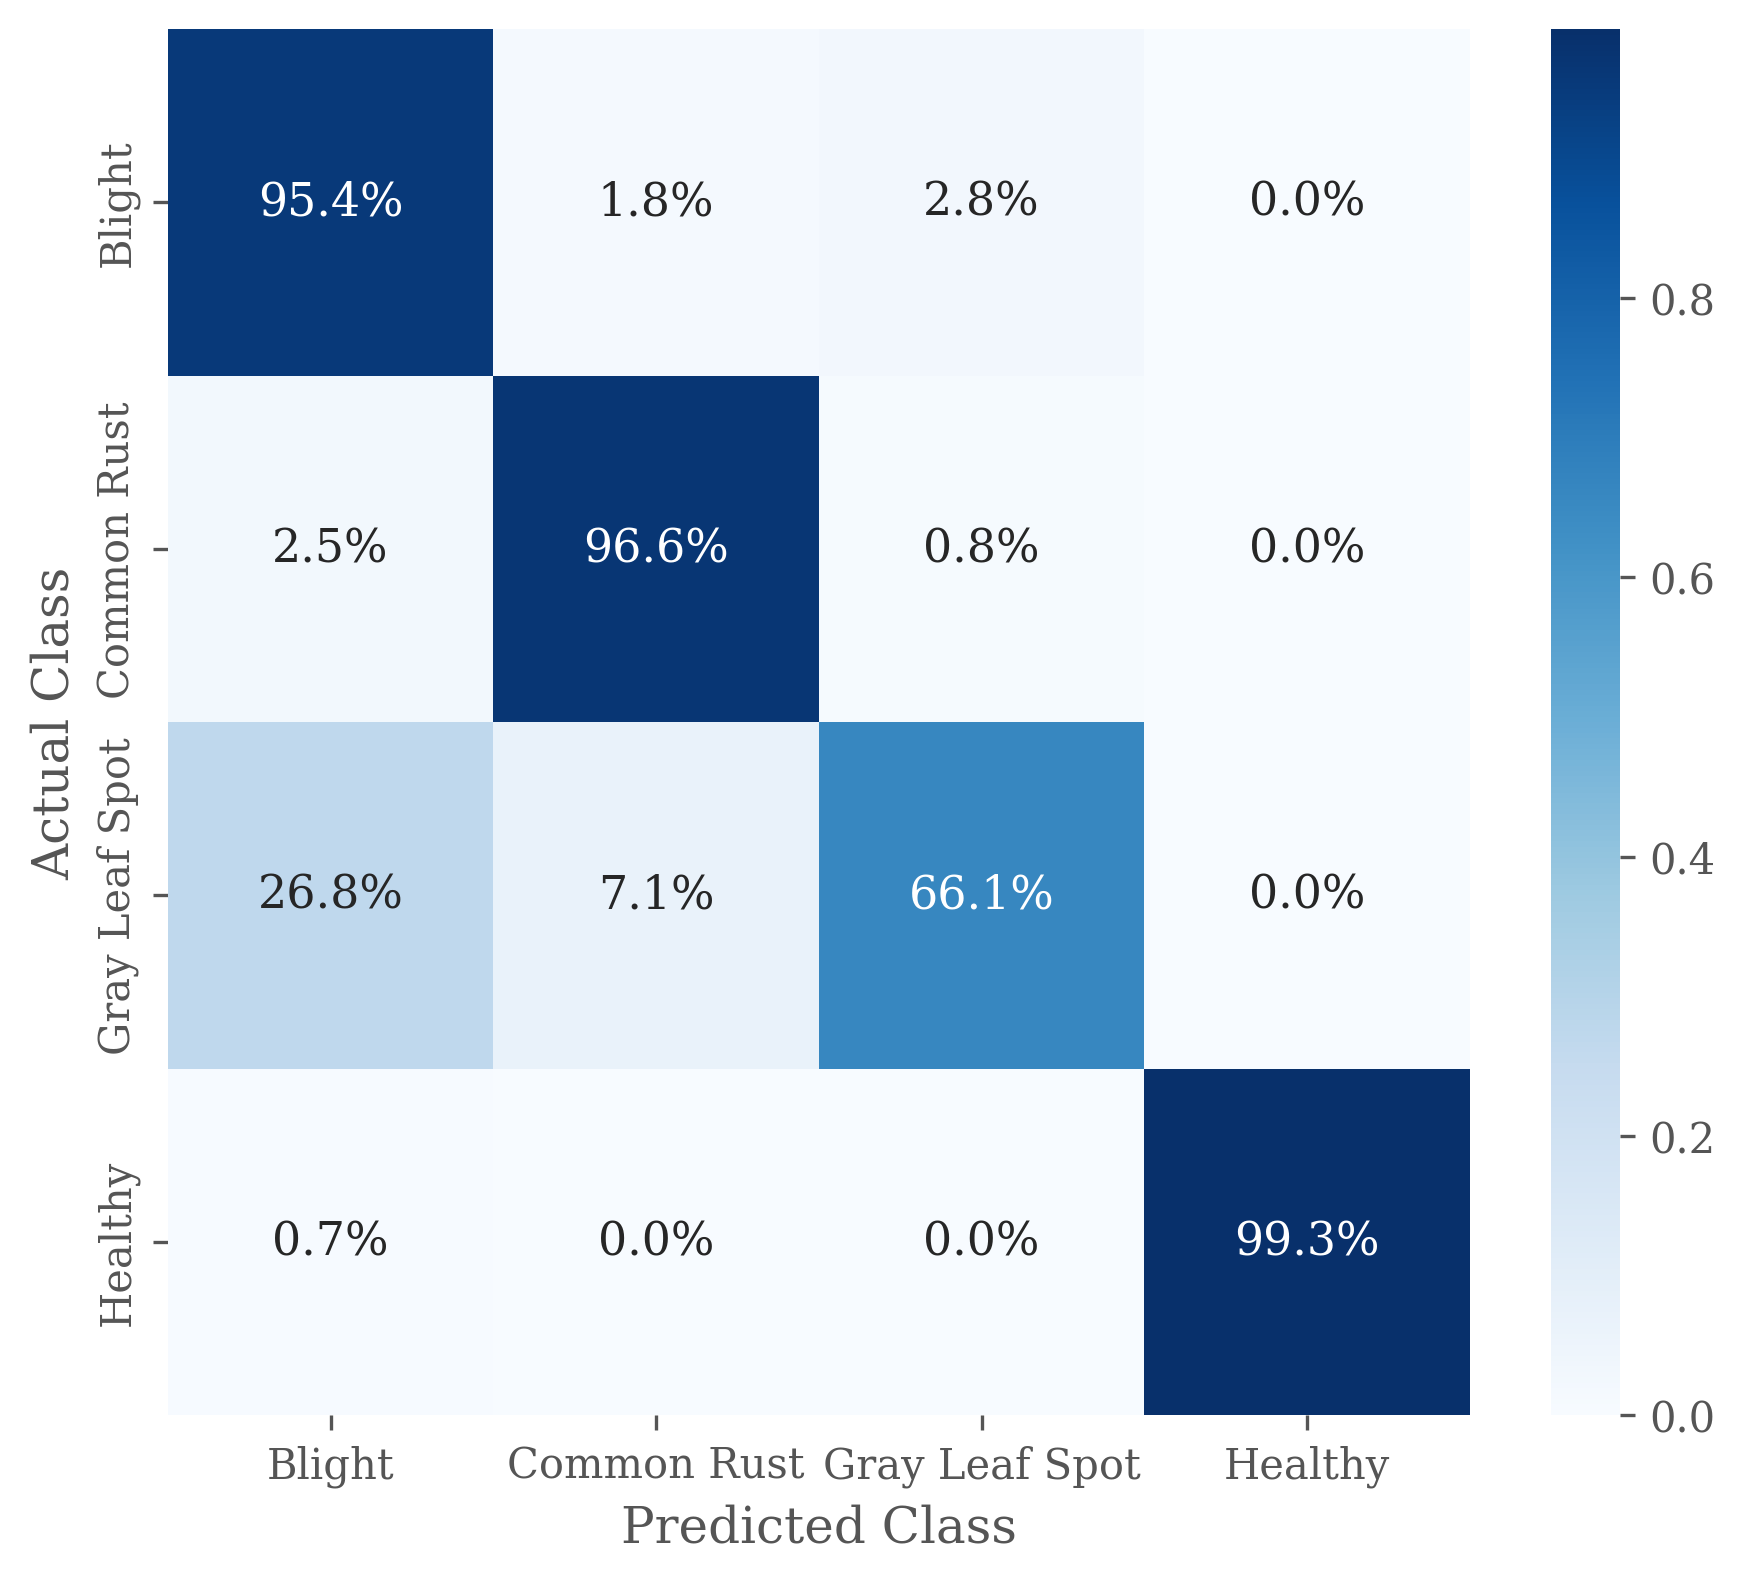

Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. 

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/07/15 09:05:59 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under dbfs:/databricks/mlflow-tracking/3077886415753277/94b1c4d8b0e04c8c9b7bc8f7ca6b99cf/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


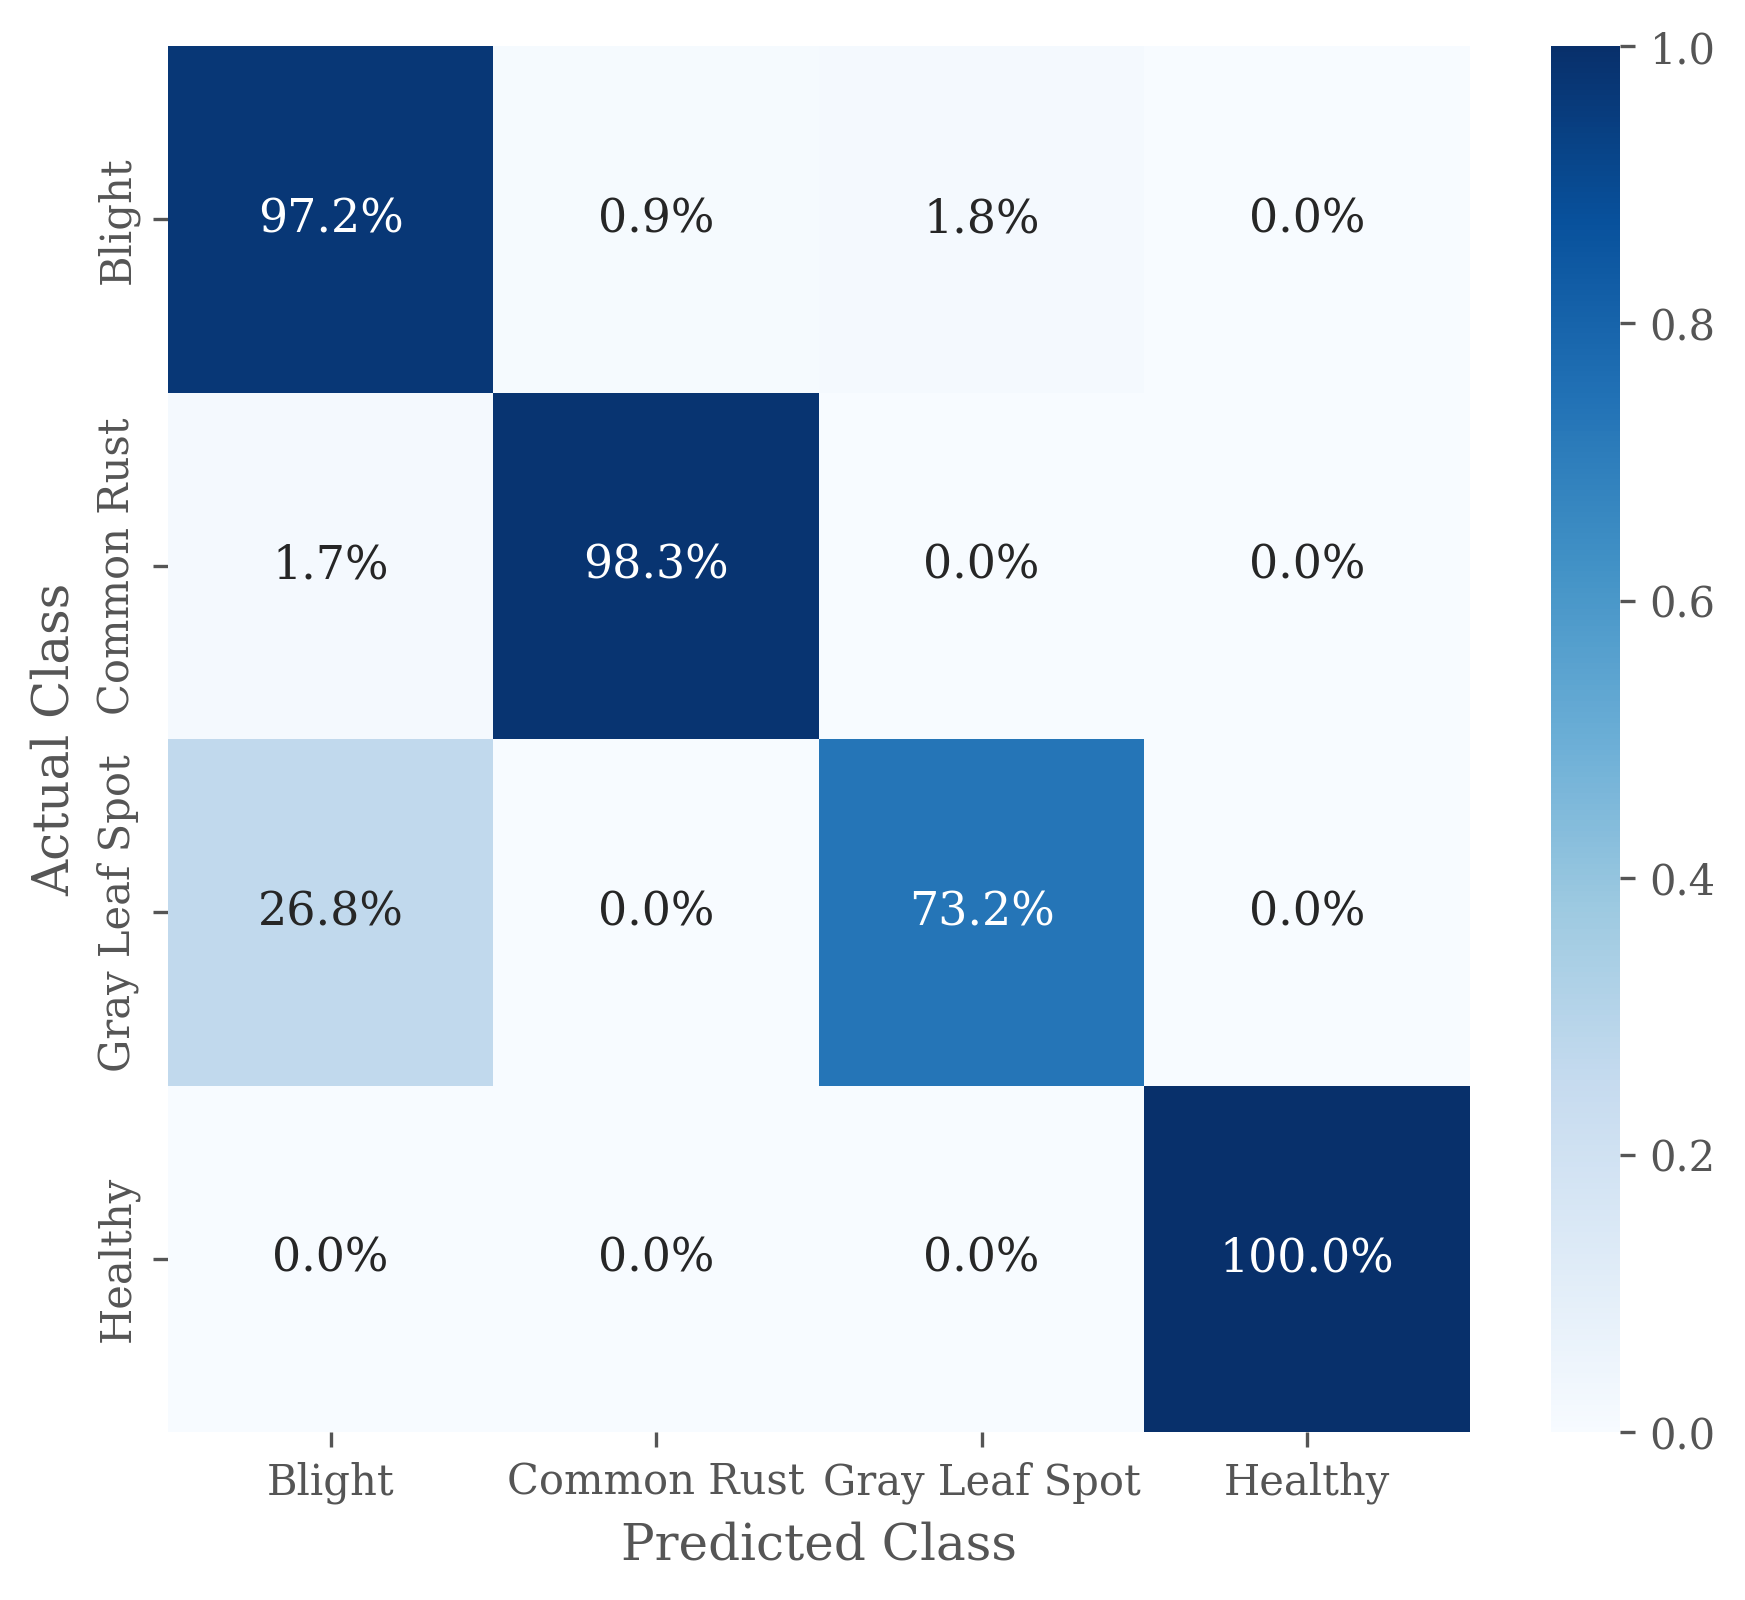

In [23]:
for fs in [True, False]:
    # with hyperparameter tuning
    _ = tune_hyperparameter(
        create_estimator(
            XGBClassifier,
            device='cuda',
            random_state=42
        ),
        {
            'max_depth': [3, 5, 7, 6],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.5, 1, 1.5, 2, 5],
        },
        select_feature=fs
    )